<a href="https://colab.research.google.com/github/KangaOnGit/Vanishing-Gradient/blob/main/Vanishing_Gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import random as rand
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch . utils . data import Dataset , DataLoader , random_split
from torchvision . datasets import FashionMNIST

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

def set_seed(seed):
  rand.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

cuda:0


In [4]:
train_dataset = FashionMNIST(root='./data', train=True,
                             download=True, transform=transforms.ToTensor())

test_dataset = FashionMNIST(root='./data', train=False,
                            download=True, transform=transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:02<00:00, 13.2MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.89MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.34MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
train_ratio = .9
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")

Sum_data = len(train_subset) + len(val_subset) + len(test_dataset)
print(f"Sum of data: {Sum_data}")

print(f"Train (%): {len(train_subset)/Sum_data}")
print(f"Validation (%): {len(val_subset)/Sum_data}")
print(f"Test (%): {len(test_dataset)/Sum_data}")

Train size: 54000
Validation size: 6000
Test size: 10000
Sum of data: 70000
Train (%): 0.7714285714285715
Validation (%): 0.08571428571428572
Test (%): 0.14285714285714285


In [6]:
class Z_Score_Normalization(nn.Module):
  def __init__(self):
    super().__init__()

    def forward(self, x):
      mean = torch.mean(x)
      std = torch.std(x)
      return (x - mean)/std

class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()
    """
      7 Layers
    """
    self.layer1 = nn.Linear(input_size, hidden_size)
    self.layer2 = nn.Linear(hidden_size, hidden_size)
    self.layer3 = nn.Linear(hidden_size, hidden_size)
    self.layer4 = nn.Linear(hidden_size, hidden_size)
    self.layer5 = nn.Linear(hidden_size, hidden_size)
    self.layer6 = nn.Linear(hidden_size, hidden_size)
    self.layer7 = nn.Linear(hidden_size, hidden_size)
    self.output = nn.Linear(hidden_size, output_size)
    self.bn = nn.BatchNorm1d(hidden_size) # Batch Normalization

    """
      Weight Initialization (Kaiming He) [Glorot is better with sigmoid/tanh]
    """
    for module in self.modules():
      if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean = 0.0, std = (2/input_size)**1/2 ) # Weight init to fit ReLU
        nn.init.constant_(module.bias, 0.0) # No Bias

    """
      Activation Function
    """
    self.sigmoid = nn.Sigmoid()
    self.relu = nn.ReLU()

  def forward(self, x):
    x = nn.Flatten()(x)

    x = self.layer1(x)
    x = self.bn(x)
    x = self.relu(x)
    identity = x

    x = self.layer2(x)
    x = self.bn(x)
    x = self.relu(x)

    x = self.layer3(x)
    x = self.bn(x)
    x = self.relu(x)
    x = identity + x # Skip to Layer 3

    x = self.layer4(x)
    x = self.bn(x)
    x = self.relu(x)
    identity = x

    x = self.layer5(x)
    x = self.bn(x)
    x = self.relu(x)

    x = self.layer6(x)
    x = self.bn(x)
    x = self.relu(x)

    x = self.layer7(x)
    x = self.bn(x)
    x = self.relu(x)
    x = identity + x # Skip to Layer 7

    output = self.output(x)

    return output

input_dims = 784
hidden_dims = 128
output_dims = 10 #10 Classes
lr = 1e-3

model = MLP(input_size = input_dims,
            hidden_size = hidden_dims,
            output_size = output_dims).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [7]:
epochs = 100
train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []

for epoch in range(epochs):
  train_loss = 0.0
  train_acc = 0.0
  count = 0
  model.train()

  for X_train, y_train in train_loader:
    X_train, y_train = X_train.to(device), y_train.to(device)

    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_acc += (torch.argmax(y_pred, 1) == y_train).sum().item()
    count += len(y_train)

  train_loss /= len(train_loader)
  train_acc /= count

  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)

  val_loss = 0.0
  val_acc = 0.0
  count = 0
  model.eval()
  with torch.no_grad():
    for X_val, y_val in val_loader:
      X_val, y_val = X_val.to(device), y_val.to(device)
      y_pred = model(X_val)
      loss = criterion(y_pred, y_val)
      val_loss += loss.item()
      val_acc += (torch.argmax(y_pred, 1) == y_val).sum().item()
      count += len(y_val)

  val_loss /= len(val_loader)
  val_acc /= count

  val_loss_list.append(val_loss)
  val_acc_list.append(val_acc)

  print(f"Epoch: {epoch+1}/{epochs}")
  print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
  print(f"Validation Loss: {val_loss: .4f} | Validation Accuracy: {val_acc: .4f}")

Epoch: 1/100
Train Loss: 0.5478 | Train Accuracy: 0.8083
Validation Loss:  0.6782 | Validation Accuracy:  0.7903
Epoch: 2/100
Train Loss: 0.3806 | Train Accuracy: 0.8623
Validation Loss:  0.7484 | Validation Accuracy:  0.7570
Epoch: 3/100
Train Loss: 0.3428 | Train Accuracy: 0.8749
Validation Loss:  0.8813 | Validation Accuracy:  0.7188
Epoch: 4/100
Train Loss: 0.3165 | Train Accuracy: 0.8860
Validation Loss:  0.8531 | Validation Accuracy:  0.7450
Epoch: 5/100
Train Loss: 0.2926 | Train Accuracy: 0.8912
Validation Loss:  0.9918 | Validation Accuracy:  0.7240
Epoch: 6/100
Train Loss: 0.2778 | Train Accuracy: 0.8978
Validation Loss:  1.0591 | Validation Accuracy:  0.6817
Epoch: 7/100
Train Loss: 0.2631 | Train Accuracy: 0.9017
Validation Loss:  1.1815 | Validation Accuracy:  0.5523
Epoch: 8/100
Train Loss: 0.2460 | Train Accuracy: 0.9090
Validation Loss:  1.1535 | Validation Accuracy:  0.6210
Epoch: 9/100
Train Loss: 0.2387 | Train Accuracy: 0.9106
Validation Loss:  1.1520 | Validation A

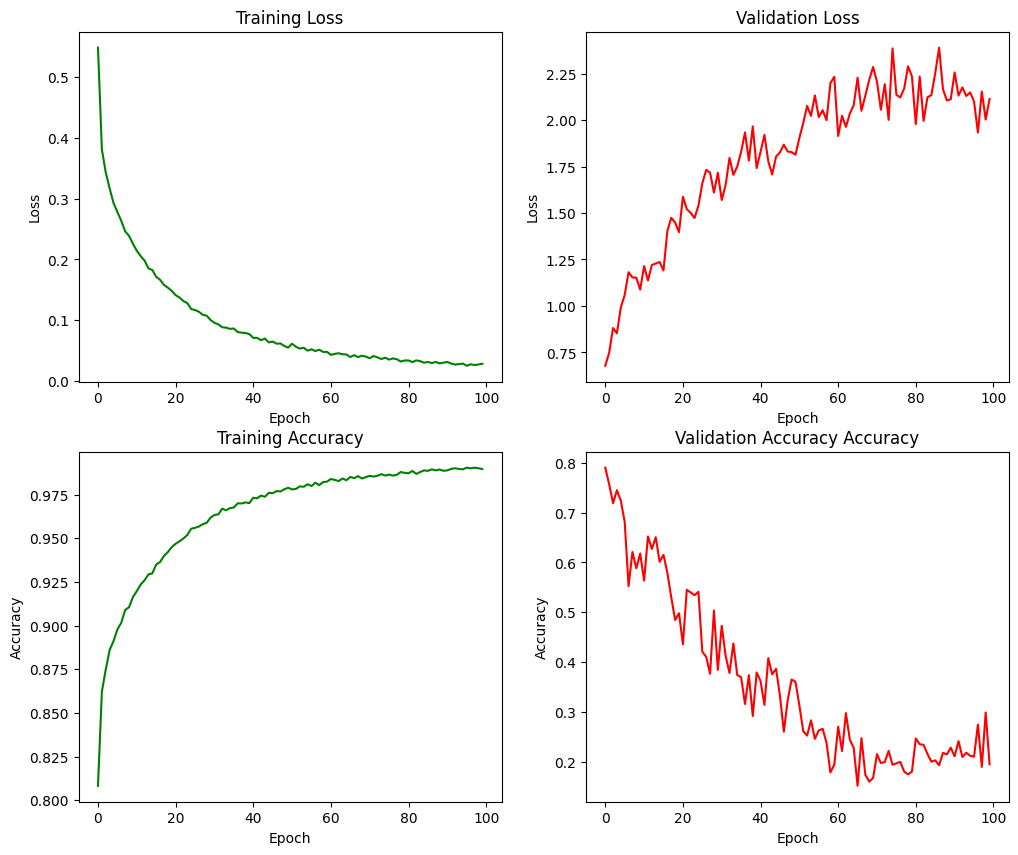

In [8]:
fig, ax = plt.subplots(2, 2, figsize = (12,10))
ax[0,0].plot(train_loss_list, color = 'green')
ax[0,0].set(xlabel = "Epoch", ylabel = "Loss")
ax[0,0].set_title("Training Loss")

ax[0,1].plot(val_loss_list, color = "red")
ax[0,1].set(xlabel = "Epoch", ylabel = "Loss")
ax[0,1].set_title("Validation Loss")

ax[1,0].plot(train_acc_list, color = "green")
ax[1,0].set(xlabel = "Epoch", ylabel = "Accuracy")
ax[1,0].set_title("Training Accuracy")

ax[1,1].plot(val_acc_list, color = "red")
ax[1,1].set(xlabel = "Epoch", ylabel = "Accuracy")
ax[1,1].set_title("Validation Accuracy Accuracy")

plt.show()

In [9]:
test_target = []
test_pred = []
model.eval()
with torch.no_grad():
  for X_test, y_test in test_loader:
    X_test, y_test = X_test.to(device), y_test.to(device)

    y_pred = model(X_test)

    test_pred.append(y_pred.cpu())
    test_target.append(y_test.cpu())
  test_pred = torch.cat(test_pred)
  test_target = torch.cat(test_target)
  test_acc = (torch.argmax(test_pred, 1) == test_target).sum().item()/len(test_target)

  print("Evaluation on test set: ")
  print(f"Accuracy: {test_acc}")

Evaluation on test set: 
Accuracy: 0.1867
